# Tuning the CIB Power Spectra Normalization

In [1]:
import numpy as np
import hmvec as hm
import matplotlib.pyplot as plt
import matplotlib

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

/tmp/ipykernel_17626/425525964.py:2: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [3]:
#Plot settings
%matplotlib inline
matplotlib.rcParams['axes.labelsize'] = 'Large'
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['axes.titlesize'] = 'xx-large'

## Setting Up

In [4]:
#Setup Grid
Nz = 60                                 # num of redshifts
Nm = 500                                # num of masses
Nk = 500                              # num of wavenumbers
redshifts = np.geomspace(0.01, 6, Nz)             
masses = np.geomspace(1e10, 1.0e16, Nm)          
ks = np.geomspace(1.0e-3, 100.0, Nk)              # wavenumbers

#Setup ells to Evaluate Cell at
lowell = 10
highell = 3000
ellstep = 15
ells = np.arange(lowell, highell, ellstep)
Nell = len(ells)

In [5]:
p18_camb = {            
    # https://github.com/cmbant/CAMB/blob/master/inifiles/planck_2018.ini
    # 'h': 0.6732,
    # 'ombh2': 0.022383,
    # 'omch2': 0.12011,
    # 'ln10^{10}A_s': 3.0448,
    # 'YHe': 0.2454006,
    # 'scalar_spectral_index': 0.96605,
    # 'tau': 0.05430842,
    # 'massless_neutrinos': 2.046,
    # 'massive_neutrinos': 1,
    # 'mnu': 0.06
    'h': 0.6711,
    'ombh2': 0.022068,
    'omch2': 0.3175-0.022068,
    'A_s': 2.2e-9,
    'scalar_spectral_index': 0.9624,
    'num_nu_massless': 0.00641,
    'massive_neutrinos': 1,
    'mnu': 0.02,
    'nu_mass_degeneracies': 3
}

In [6]:
#Initialize Halo Model(s)
hcos1 = hm.HaloModel(redshifts, ks, ms=masses, params=p18_camb, mdef='mean')
hcos2 = hm.HaloModel(redshifts, ks, ms=masses, mdef='mean')
# hcosv = hm.HaloModel(redshifts, ks, ms=masses, mdef='vir')

In [7]:
Loscale = 1

In [8]:
#Set the Normalization
Lo = 6.4e-8 * Loscale

#Set CIB Parameters
hcos1.set_cibParams('planck13', L_o = Lo)
hcos2.set_cibParams('planck13', L_o = Lo)

# hcosv.set_cibParams('planck13', L_o = Lo)

Ignore this cell:

In [9]:
Pii = hcosm.get_power('cib', nu_obs=np.array([545e9]))
Cii = hcosm.C_ii(ells, redshifts, ks, Pii)
plt.loglog(ells, Cii1100, label='z < 1100')
plt.loglog(ells, Cii100, '--', label='z < 100')
plt.loglog(ells, Cii20, label='z < 20')
plt.loglog(ells, Cii50, '--', label='z < 50')
plt.loglog(ells, Cii100lin, '--', label='z < 100, linear')
plt.legend();

In [9]:
#Data/Freqs to Cross Correlate
# filenames = ['data/cibplanck_3000.txt','data/cibplanck_545.txt','data/cibplanck_217.txt']
# frequencies = np.array([3000, 545, 217])*1e9    #These must go from high to low!
filenames = ['data/cibplanck_3000.txt','data/cibplanck_857.txt','data/cibplanck_545.txt','data/cibplanck_353.txt','data/cibplanck_217.txt']
# filenames = ['data/cibplanck_3000.txt','data/cibplanck_857.txt','data/cibplanck_545.txt','data/cibplanck_353.txt','data/cibplanck_217.txt','data/cibplanck_143.txt']
frequencies = np.array([3000, 857, 545, 353, 217])*1e9
# frequencies = np.array([3000, 857, 545, 353, 217, 143])*1e9
Nfreq = len(frequencies)
Nfiles = len(filenames)

In [10]:
#Read in Placnk 2013 Poisson Noise
poisson = np.loadtxt('data/poisson.txt')

## Calculate the Power Spectra

In [11]:
h1flag = False
h2flag = False

In [12]:
def getCls(hcos, freqs, Nfiles, h1, h2):
    #Initializations
    Nfreq = len(frequencies)
    C_tots = np.zeros((Nfreq, Nfiles, len(ells)))
    if h1:
        C_1hs = np.zeros((Nfreq, Nfiles, len(ells)))
    if h2:
        C_2hs = np.zeros((Nfreq, Nfiles, len(ells)))

    #Calculations
    for i, f1 in enumerate(freqs):
        for j, f2 in enumerate(freqs):
            freqarray = np.array([[f1],[f2]], dtype=np.double)  

            #Get 3D Power Spectra P(z,k)
            Pjj_tot = hcos.get_power("cib", "cib", nu_obs=freqarray, satmf = 'tinker')
            if h1:
                Pjj_1h = hcos.get_power_1halo("cib", "cib", nu_obs=freqarray, satmf = 'tinker')  
            if h2:
                Pjj_2h = hcos.get_power_2halo("cib", "cib", nu_obs=freqarray, satmf = 'tinker')  

            #Limber Integrals
            C_tots[j,i] = hcos.C_ii(ells, redshifts, ks, Pjj_tot, dcdzflag=False)      
            if h1:
                C_1hs[j,i] = hcos.C_ii(ells, redshifts, ks, Pjj_1h, dcdzflag=False)
            if h2:
                C_2hs[j,i] = hcos.C_ii(ells, redshifts, ks, Pjj_2h, dcdzflag=False)
    
    #Pack Cls for Delivery
    allCls = [C_tots]
    if h1:
        allCls.append(C_1hs)
    else:
        allCls.append('Not calculated')
    if h2:
        allCls.append(C_2hs)
    else:
        allCls.append('Not calculated')
    return allCls

In [13]:
#Calculate the Cls
Cls_1 = getCls(hcos1, frequencies, Nfiles, h1flag, h2flag)
Cls_2 = getCls(hcos2, frequencies, Nfiles, h1flag, h2flag)

In [14]:
#Pack the Cls
Cl_all = {'nondefault': Cls_1}
Cl_all['default'] = Cls_2

## Plot Everything

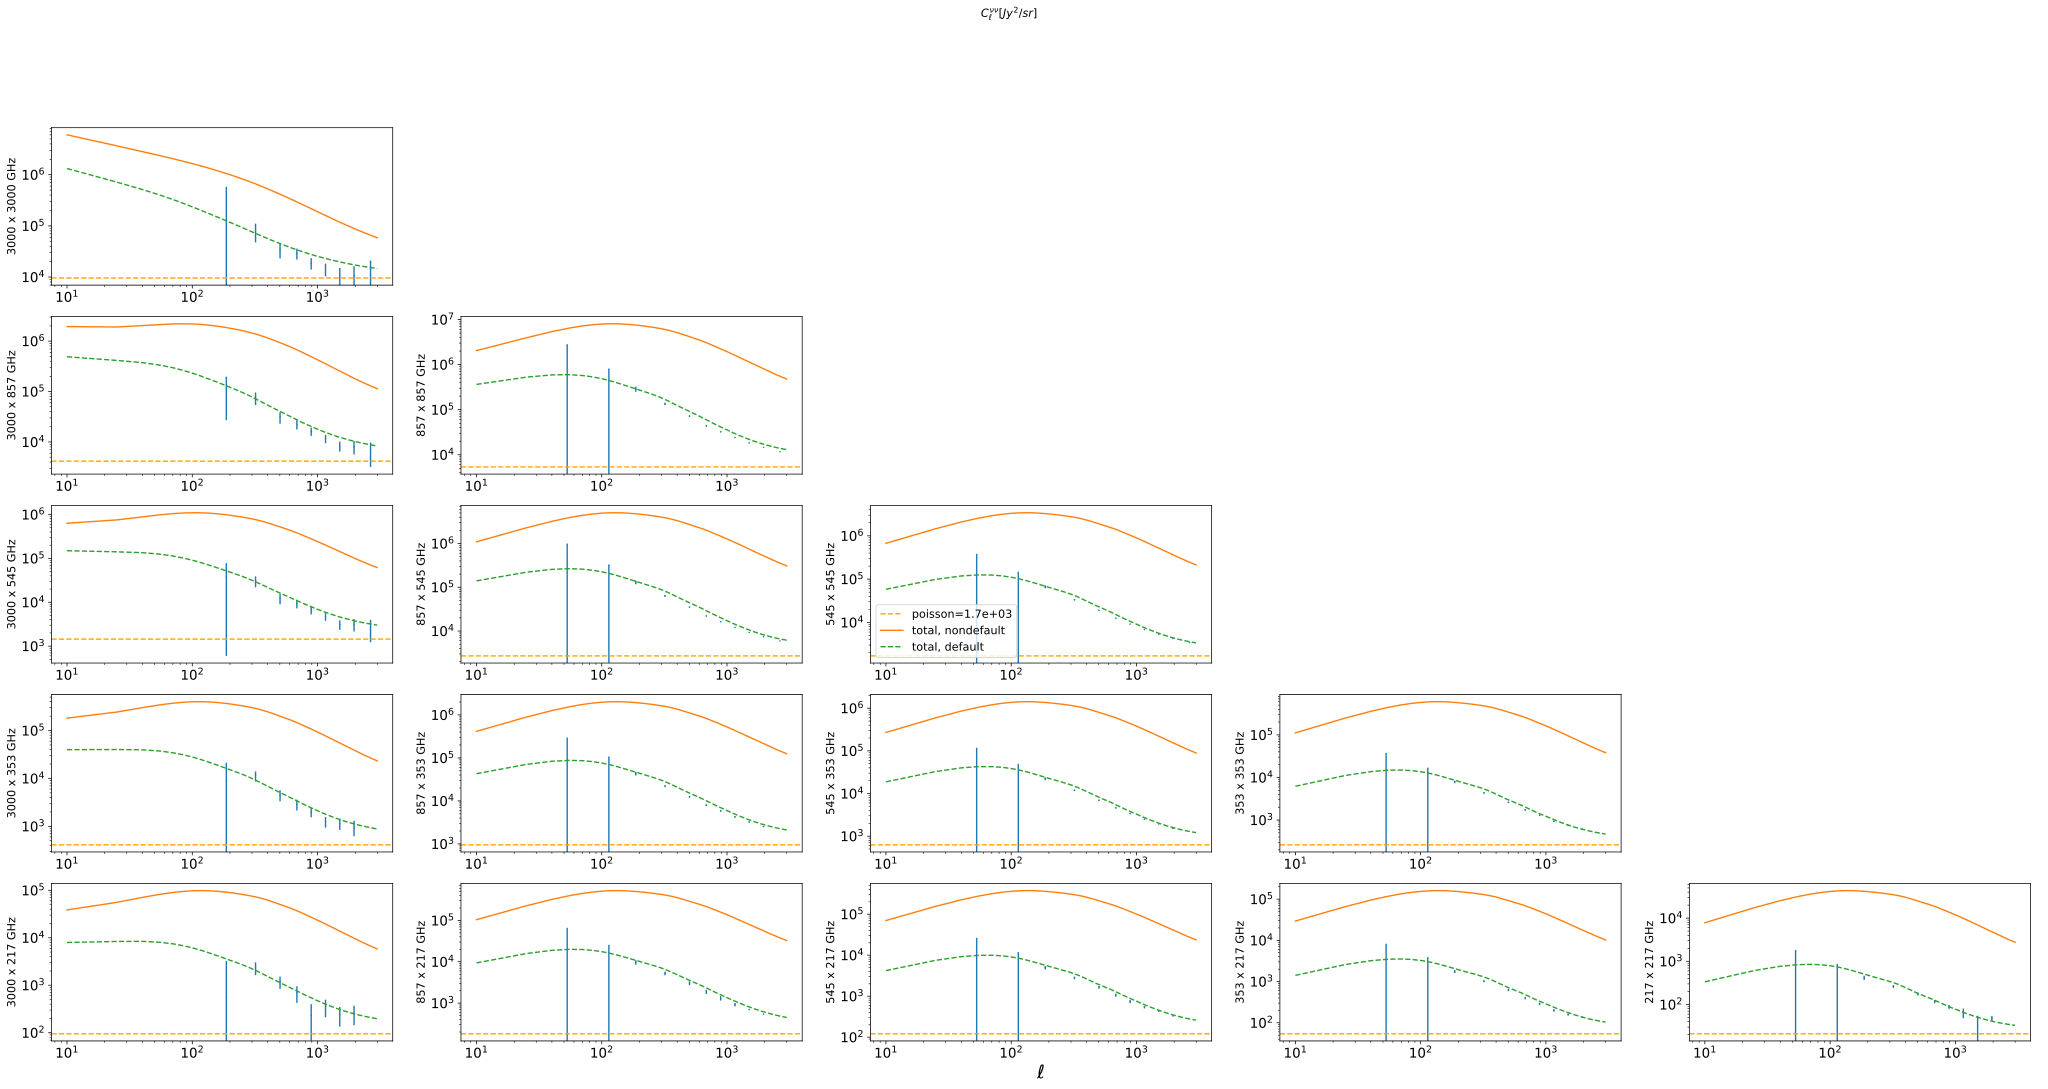

In [15]:
freqdict = {3000e9: 0, 857e9: 1, 545e9: 2, 353e9: 3, 217e9: 4, 143e9: 5}
labels = ['total', '1 halo', '2 halo']
pltctr = 0

#Set the Figure
fig, ax = plt.subplots(Nfreq, Nfiles, figsize=(38, 18))

#Read in the Data
for icol, fname in enumerate(filenames):
    ells_data = np.loadtxt(fname, usecols=0)
    data = np.loadtxt(fname, usecols=(1, 4, 7, 10, 13, 16))
    err = np.loadtxt(fname, usecols=(2, 5, 8, 11, 14, 17))
    uplim = np.genfromtxt(fname, dtype=bool, usecols=(3, 6, 9, 12, 15, 18))
    
    #Plot
    for irow, freq in enumerate(frequencies):
        #Make it a corner plot
        if (irow < icol) or (irow == 5 and icol == 0):
            ax[irow, icol].axis('off')
            continue
        
        #Connect Column from Data Table to Frequency
        idatacol = freqdict[freq]
        
        #Plot Data Points
        ax[irow, icol].errorbar(ells_data, data[:,idatacol], yerr=err[:,idatacol], ls='none', marker='.', markersize=1, uplims=uplim[:,idatacol])
        
        #Plot Poisson
        ax[irow, icol].axhline(y=poisson[pltctr], ls='--', color='orange', label=f'poisson={poisson[pltctr]:0.1e}')
        
        #Plot Cls
        for cosmo, Cls in Cl_all.items():
            for iCl, Cl in enumerate(Cls):
                if type(Cl) == str:
                    continue
                elif len(Cl_all.keys()) == 2:
                    if cosmo=='default':
                        ax[irow, icol].plot(ells, Cl[irow, icol, :] + poisson[pltctr], '--', label= labels[iCl] + ', ' + cosmo)
                    else:
                        ax[irow, icol].plot(ells, Cl[irow, icol, :] + poisson[pltctr], '-', label= labels[iCl] + ', ' + cosmo)
                else:
                    ax[irow, icol].plot(ells, Cl[irow, icol, :] + poisson[pltctr])
        
        #Gravy
        ax[irow, icol].set_xscale('log')
        ax[irow, icol].set_yscale('log')
        ax[irow, icol].set_ylabel(f'{frequencies[icol]/1e9:.0f} x {frequencies[irow]/1e9:.0f} GHz')
        if len(Cl_all.keys()) == 2:
            if irow==(Nfreq//2) and icol==(Nfreq//2):
                ax[irow, icol].legend()
        
        pltctr+= 1

#Set Super Axis Labels
fig.suptitle(r'$C_\ell^{\nu\nu} [Jy^2 / sr]$')
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r'$\ell$', fontsize=20);

fig.savefig('cibps.png', bbox_inches='tight', dpi=500);

To quickly modify the spectra, multiply them directly by the corrected amplitude^2, as done in the following cell.

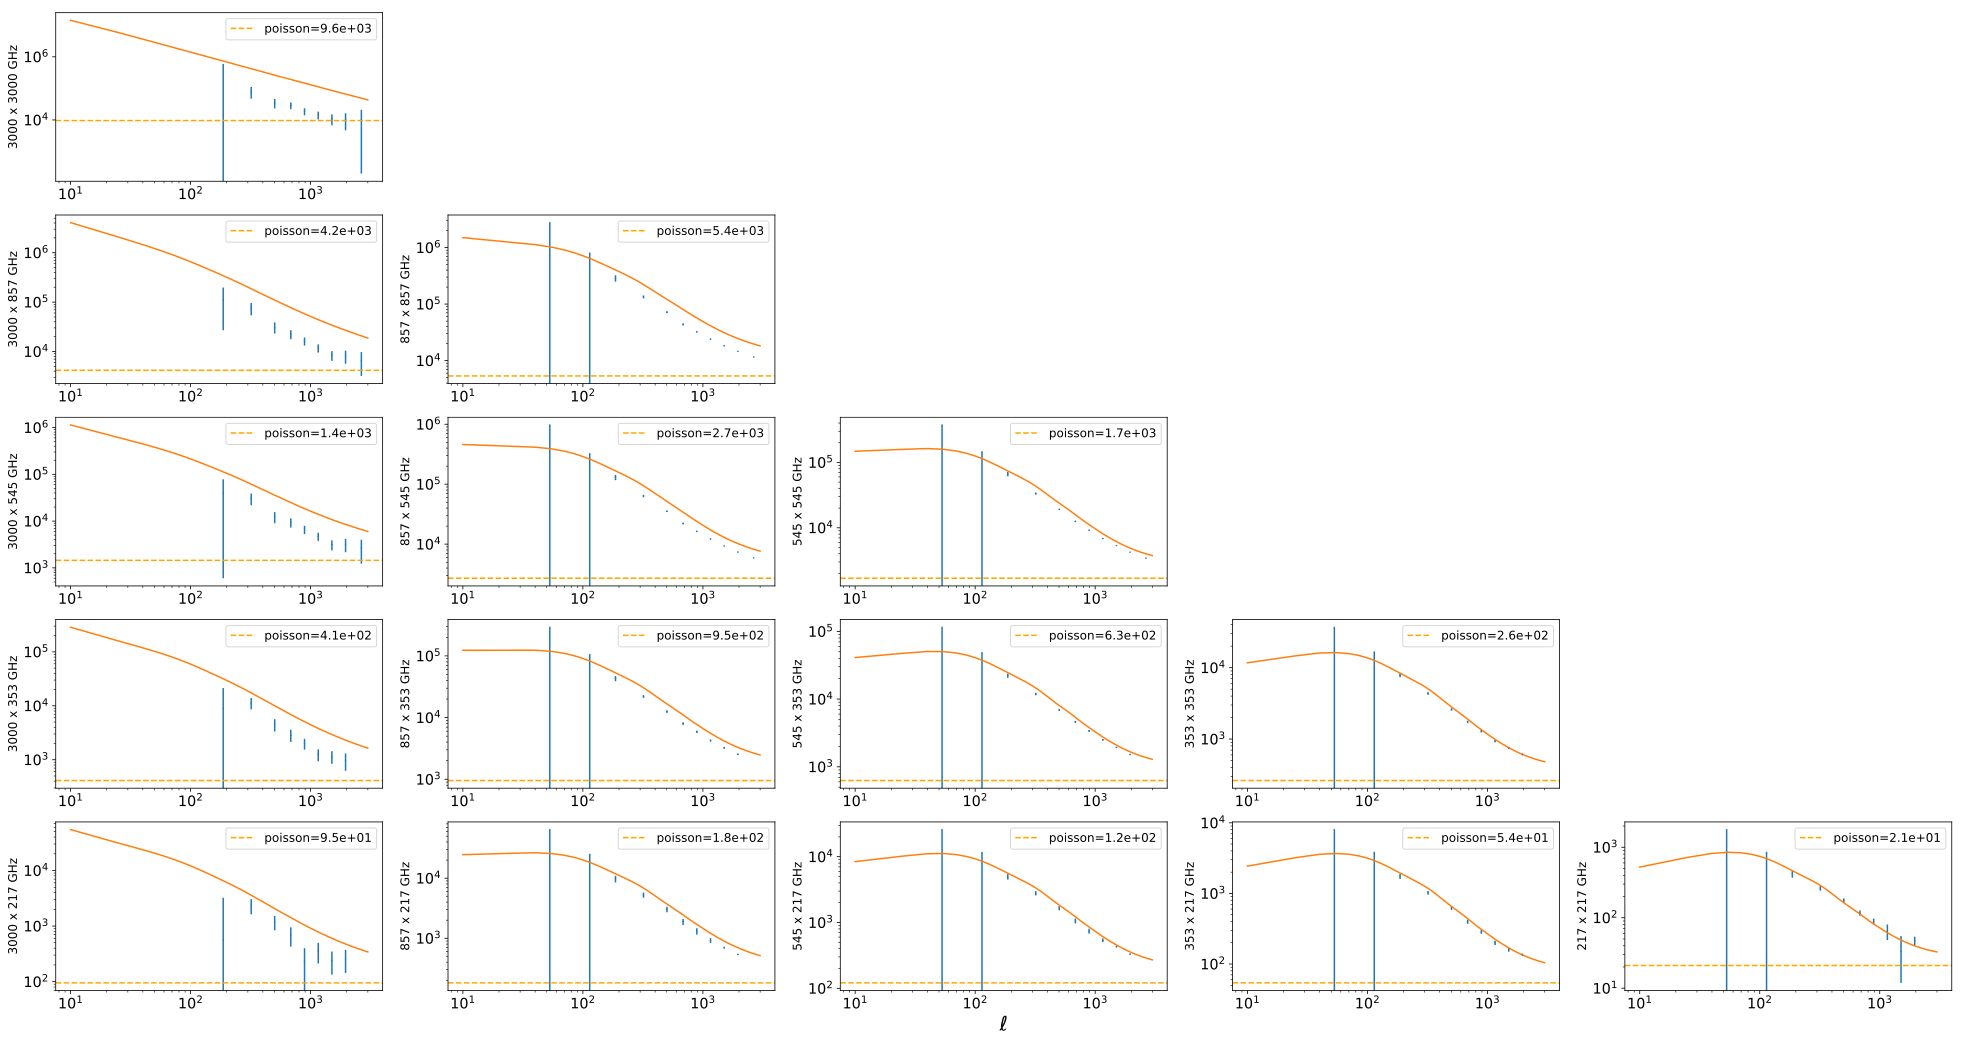

In [91]:
freqdict = {3000e9: 0, 857e9: 1, 545e9: 2, 353e9: 3, 217e9: 4, 143e9: 5}
labels = ['total', '1 halo', '2 halo']
pltctr = 0

#Set the Figure
fig, ax = plt.subplots(Nfreq, Nfiles, figsize=(34, 18))

#Read in the Data
for icol, fname in enumerate(filenames):
    ells_data = np.loadtxt(fname, usecols=0)
    data = np.loadtxt(fname, usecols=(1, 4, 7, 10, 13, 16))
    err = np.loadtxt(fname, usecols=(2, 5, 8, 11, 14, 17))
    uplim = np.genfromtxt(fname, dtype=bool, usecols=(3, 6, 9, 12, 15, 18))
    
    #Plot
    for irow, freq in enumerate(frequencies):
        #Make it a corner plot
        if (irow < icol) or (irow == 5 and icol == 0):
            ax[irow, icol].axis('off')
            continue
        
        #Connect Column from Data Table to Frequency
        idatacol = freqdict[freq]
        
        #Plot Data Points
        ax[irow, icol].errorbar(ells_data, data[:,idatacol], yerr=err[:,idatacol], ls='none', marker='.', markersize=1, uplims=uplim[:,idatacol])
        
        #Plot Poisson
        ax[irow, icol].axhline(y=poisson[pltctr], ls='--', color='orange', label=f'poisson={poisson[pltctr]:0.1e}')
        
        #Plot Cls
        for mdef, Cls in Cl_mvs.items():
            for iCl, Cl in enumerate(Cls):
                if type(Cl) == str:
                    continue
                elif len(Cl_mvs.keys()) == 2:
                    if mdef=='vir':
                        ax[irow, icol].plot(ells, Loscale**2 * Cl[irow, icol, :] + poisson[pltctr], '--', label= labels[iCl] + ', ' + mdef)
                    else:
                        ax[irow, icol].plot(ells, Loscale**2 * Cl[irow, icol, :] + poisson[pltctr], '-', label= labels[iCl] + ', ' + mdef)
                else:
                    ax[irow, icol].plot(ells, Loscale**2 * Cl[irow, icol, :] + poisson[pltctr])
        
        #Gravy
        ax[irow, icol].set_xscale('log')
        ax[irow, icol].set_yscale('log')
        ax[irow, icol].set_ylabel(f'{frequencies[icol]/1e9:.0f} x {frequencies[irow]/1e9:.0f} GHz')
#         if len(Cl_mvs.keys()) == 2:
#             if irow==1 and icol==1:
#                 ax[irow, icol].legend()
        ax[irow, icol].legend()

        
        pltctr+= 1

#Set Super Axis Titles
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.ylabel(r'$C_\ell$', fontsize=20)
plt.xlabel(r'$\ell$', fontsize=20);